#SubGraph Shared State


In [29]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

In [30]:
from pydantic_core.core_schema import date_schema
class states(TypedDict):
  question : str
  date : str
  similar_events : str

In [32]:
parent_llm = ChatOpenAI()
child_llm = ChatOpenAI()

In [33]:
def subgraph(state:states):
  prompt = f"For the above given date,give other important events which have happened on this date: {state['date']} "

  events = parent_llm.invoke(prompt).content
  return {'similar_events':events}

In [34]:
graph = StateGraph(states)
graph.add_node('subgraph',subgraph)
graph.add_edge(START,'subgraph')
graph.add_edge('subgraph',END)

subgraphs = graph.compile()

In [35]:
def parent(state:states):
  prompt = f"For the event in the question, give the date of the particular event: {state['question']} "

  dates = child_llm.invoke(prompt).content
  return {'date':dates}

In [38]:
parent_graph = StateGraph(states)
parent_graph.add_node('parent',parent)
parent_graph.add_node('subgraph',subgraphs)
parent_graph.add_edge(START,'parent')
parent_graph.add_edge('parent','subgraph')
parent_graph.add_edge('subgraph',END)

subgraphs = parent_graph.compile()

In [39]:
result=  subgraphs.invoke({'question': 'When did India win T20 world cup'})
result

{'question': 'When did India win T20 world cup',
 'date': 'India won the T20 World Cup on September 24, 2007.',
 'similar_events': "1. In 2013, the United Nations Security Council unanimously passes a resolution on Syria's chemical weapons.\n2. In 2009, President Barack Obama criticizes Iran for building a secret nuclear facility during a G20 summit in Pittsburgh.\n3. In 1992, the Mars Observer spacecraft disappears as it was about to go into orbit around the red planet.\n4. In 1968, 60 Minutes, an American television newsmagazine program, premieres on CBS.\n5. In 1957, President Dwight D. Eisenhower sends federal troops to Little Rock, Arkansas, to enforce desegregation at Central High School."}

#Different states

In [40]:
class SubState(TypedDict):

    input_text: str
    output_text: str

In [41]:
subgraph_llm = ChatOpenAI(model='gpt-4o')

In [44]:
def give_event(state: SubState):

    prompt = f"For the given date,give other important events which have happened around this date: {state['input_text']} "

    output = subgraph_llm.invoke(prompt).content

    return {'output_text': output}

In [45]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('give_event', give_event)

subgraph_builder.add_edge(START, 'give_event')
subgraph_builder.add_edge('give_event', END)

subgraph = subgraph_builder.compile()

In [46]:
class ParentState(TypedDict):

    question: str
    date: str
    event : str


In [47]:
parent_llm = ChatOpenAI(model='gpt-4o-mini')

In [48]:
def generate_date(state: ParentState):

    answer = parent_llm.invoke(f"For the event in the question, give the date of the particular event: {state['question']} ").content
    return {'date': answer}

In [49]:
def give_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['date']})

    return {'event': result['output_text']}

In [52]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("generate_date", generate_date)
parent_builder.add_node("give_answer", give_answer)

parent_builder.add_edge(START, 'generate_date')
parent_builder.add_edge('generate_date', 'give_answer')
parent_builder.add_edge('give_answer', END)

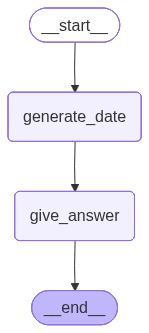

In [53]:
graph = parent_builder.compile()

graph

In [54]:
result=  subgraphs.invoke({'question': 'When did India win ODI world cup'})
result

{'question': 'When did India win ODI world cup',
 'date': 'India won the ODI World Cup on April 2, 2011.',
 'similar_events': 'April 2 has seen several significant events in history across various fields. Here are some notable occurrences on this date:\n\n1. **1917** - In the United States, President Woodrow Wilson asked Congress to declare war against Germany, marking the entry of the U.S. into World War I.\n\n2. **1972** - The final episode of the popular television series "The Ed Sullivan Show" aired, marking an end to an influential variety show that showcased many famous acts.\n\n3. **1982** - The Falklands War began when Argentina invaded the Falkland Islands, leading to a conflict with the United Kingdom.\n\n4. **2005** - Pope John Paul II passed away at the age of 84 after a long illness, marking the end of one of the longest papacies in history.\n\n5. **2008** - The first edition of the "American Idol" winner was declared as David Cook, who took home the title in the show\'s s